In [1]:
# # DATA_PATH = '../input/'
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [1]:
%cd '/home/ec2-user/SageMaker/dl-ecommerce-duplicates/'

/home/ec2-user/SageMaker/dl-ecommerce-duplicates


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

/bin/sh: apt: command not found
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
import numpy as np
import pandas as pd
import matplotlib

import torch
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
from modules.datasets.ImageShopeeDataset import ImageShopeeDataset
from modules.datasets.TextShopeeDataset import TextShopeeDataset
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
from modules.models.BERTPreTrainedEmbeddingsShopeeNet import BERTPreTrainedEmbeddingsShopeeNet
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import faiss
from torch import nn
import torchvision.models as models
from transformers import BertModel,XLNetModel
from modules.losses.ArcFaceLoss import ArcFaceLoss
from modules.cfg.BertArcFaceLossCFG import BertArcFaceLossCFG as CFG
from modules.datasets.TextArcFaceLossShopeeDataset import TextArcFaceLossShopeeDataset
from modules.models.BertWithArcFace import BertWithArcFace

In [5]:
#Helper Functions
def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

def calc_f1_score(targets, results):
    intersect = len(np.intersect1d(targets, results))
    return 2 * intersect / (len(targets) + len(results))


def process_for_threshold(df,similarities, indexes, threshold, embeddings):
    f1_score_accumulated = 0
    for i in range(len(embeddings)):
        cur_sims = similarities[i]
        cur_indexes = indexes[i]
        duplicate_indexes = cur_indexes[cur_sims >= threshold]
        results = df.iloc[duplicate_indexes]['posting_id'].values
        targets = df.iloc[i]['target']
        f1_score = calc_f1_score(targets, results)
        f1_score_accumulated += f1_score
    return f1_score_accumulated / len(embeddings)

In [6]:
DATA_FOLDER = '../shopee-product-matching/'

IS_TEST = False

def get_dataset(root=DATA_FOLDER, is_test=False):
    name = "test.csv" if is_test else "train.csv"
    df = pd.read_csv(DATA_FOLDER + name)
    images_folder = "test_images/" if is_test else "train_images/"
    df['image'] = DATA_FOLDER + images_folder + df['image']
    return df

def add_target(df):
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    target = df['label_group'].map(grouped)
    new_df = df.copy()
    new_df['target'] = target
    return new_df

df = get_dataset(is_test=IS_TEST)
df = add_target(df)
# train = df[df['image'].apply(lambda x: os.path.exists(x))] 
train = df.copy()
num_classes = train['label_group'].nunique()
train = train.head(2500)
train.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,../shopee-product-matching/train_images/0000a6...,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,../shopee-product-matching/train_images/000397...,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,../shopee-product-matching/train_images/000a19...,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,../shopee-product-matching/train_images/00117e...,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,../shopee-product-matching/train_images/00136d...,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [7]:
from sklearn.preprocessing import LabelEncoder
lbl_encoder = LabelEncoder()
train['label_code'] = lbl_encoder.fit_transform(train['label_group'])
num_classes = train['label_code'].nunique()

#### TFIDF Embeddings

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
model = TfidfVectorizer(stop_words=None, binary=True, max_features=500)
text_embeddings = model.fit_transform(train.title).toarray()
print('text embeddings shape',text_embeddings.shape)

text embeddings shape (2500, 500)


In [86]:
text_embeddings.shape

(2500, 500)

In [ ]:
# embeds = torch.tensor(text_embeddings)
# embedding_loader = torch.utils.data.DataLoader(
#     text_embeddings,
#     batch_size=50,
#     shuffle=False,
#     num_workers=4
# )

# # compute the pairwise cosine similarity between embeddings
# indices = []
# i = 1
# for batch in tqdm(embedding_loader):
#     # compute the pairwise cosine similarity within the batch
#     cts = F.normalize(batch) @ F.normalize(embeds).t()
#     indices.extend(torch.topk(cts, k=2).indices.data.cpu().numpy())

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 685/685 [18:54<00:00,  1.66s/it]


In [ ]:
# indices = np.array(indices)
# idx1 = indices[:,0]
# idx2 = indices[:,1]
# train['oof_text1'] = train.iloc[idx1].posting_id.values
# train['oof_text2'] = train.iloc[idx2].posting_id.values
# train['oof_text'] = train[['oof_text1','oof_text2']].values.tolist()
# train['f1'] = train.apply(getMetric('oof_text'),axis=1)
# print('CV score for baseline =',train.f1.mean())

CV score for baseline = 0.5658283955518305


In [ ]:
#### TFIDF

#### Pure BERT Embeddings

In [60]:
# Prepare DataLoaders
# from transformers import GPT2Tokenizer, GPT2Model,XLNetTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
text_dataset = TextShopeeDataset(train['title'].values)

def my_collate_fn(data):
    """
    data: list of input text strings
    return: dict with keys: input_ids, token_type_ids, attention_mask where each key is a tensor
    """
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    # tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    # Set padding token to eos_token
    # tokenizer.pad_token = tokenizer.eos_token
    inputs = tokenizer(data, padding=True, return_tensors="pt")
    return inputs
    
text_loader = torch.utils.data.DataLoader(
    text_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

In [61]:
DEVICE = 'cuda'
bert_pretrain_model = BERTPreTrainedEmbeddingsShopeeNet()
# bert_pretrain_model = GPT2Model.from_pretrained('gpt2')
bert_pretrain_model.to(DEVICE)

text_embeddings = []
with torch.no_grad():
    for data in tqdm(text_loader):
        
        # Check if a GPU is available
        if torch.cuda.is_available():
            # Move the inputs to the GPU
            data = {name: tensor.to('cuda') for name, tensor in data.items()}
        else:
            print('GPU not available')
        
        embeddings = bert_pretrain_model(data)
        embeddings = embeddings.data.cpu().numpy()
        text_embeddings.extend(embeddings)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/40 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

 98%|█████████▊| 39/40 [00:07<00:00,  4.42it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 40/40 [00:07<00:00,  5.64it/s]


In [62]:
del embeddings
del df

In [63]:
text_embeddings = np.stack(text_embeddings)
norms = np.linalg.norm(text_embeddings, axis=1)
text_embeddings = text_embeddings / norms[:, np.newaxis]
text_embeddings.shape

(2500, 768)

#### Embeddings Using ARCFACE Loss

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_dataset = TextArcFaceLossShopeeDataset(train, tokenizer, max_length=CFG.max_length)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=CFG.batch_size, 
                                           num_workers=CFG.num_workers, 
                                           shuffle=True)

In [9]:
### Training
mode = "train"
step = "batch"
model = BertWithArcFace(num_classes).to(CFG.device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
criterion = nn.CrossEntropyLoss()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

if CFG.scheduler == "ReduceLROnPlateau":
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                              mode="min", 
                                                              factor=CFG.factor, 
                                                              patience=CFG.patience)
for epoch in range(3):
      print("*" * 30)
      print(f"Epoch {epoch + 1}")
      current_lr = get_lr(optimizer)
      
      model.train()

      tqdm_object = tqdm(train_loader)
      for batch,labels in tqdm_object:
          batch = {k: v.to(CFG.device) for k, v in batch.items()}
          labels = labels.to(CFG.device)
          preds = model(batch,labels)
          loss = criterion(preds, labels)
          if mode == "train":
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              if step == "batch":
                lr_scheduler.step(loss)

      model.eval()

# torch.save(model.state_dict(), f'{CFG.model_path}/{CFG.model_save_name}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


******************************
Epoch 1


  0%|          | 0/40 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

 98%|█████████▊| 39/40 [00:12<00:00,  3.36it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


******************************
Epoch 2


  0%|          | 0/40 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

 98%|█████████▊| 39/40 [00:11<00:00,  3.32it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 40/40 [00:11<00:00,  3.37it/s]


******************************
Epoch 3


  0%|          | 0/40 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

 98%|█████████▊| 39/40 [00:11<00:00,  3.28it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 40/40 [00:12<00:00,  3.32it/s]


In [11]:
val_dataset = TextArcFaceLossShopeeDataset(train, tokenizer, max_length=CFG.max_length)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                           batch_size=CFG.batch_size, 
                                           num_workers=CFG.num_workers, 
                                           shuffle=True)

In [12]:
tqdm_object = tqdm(val_loader, total=len(val_loader))
predictions = []
for batch, _ in tqdm_object:
    batch = {k: v.to(CFG.device) for k, v in batch.items()}
    preds = model(batch)
    predictions.extend(preds.data.cpu().numpy())
del preds, val_loader, tqdm_object

  0%|          | 0/40 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  2%|▎         | 1/40 [00:00<00:07,  5.44it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 98%|█████████▊| 39/40 [00:03<00:00, 10.73it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


In [13]:
predictions[0].shape

(768,)

In [14]:
text_embeddings = np.array(predictions)
text_embeddings.shape
# text_embeddings = text_embeddings[:,:768]
# del predictions

(2500, 768)

#### Faiss

In [64]:
text_embeddings = np.stack(text_embeddings)
norms = np.linalg.norm(text_embeddings, axis=1)
text_embeddings = text_embeddings / norms[:, np.newaxis]
text_embeddings.shape

(2500, 768)

In [65]:
k = 50
res = faiss.StandardGpuResources()
index_text = faiss.IndexFlatIP(text_embeddings.shape[1])
index_text.add(text_embeddings)
similarities_text, indexes_text = index_text.search(text_embeddings, k)

In [66]:
# del embedding_loader
# del text_embeddings

In [67]:
thresholds = np.arange(0.92, 0.99, 0.01)
f1_avg_scores = []
for threshold in tqdm(thresholds):
    f1_avg = process_for_threshold(train,similarities_text, indexes_text, threshold, text_embeddings)
    f1_avg_scores.append(f1_avg)

100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


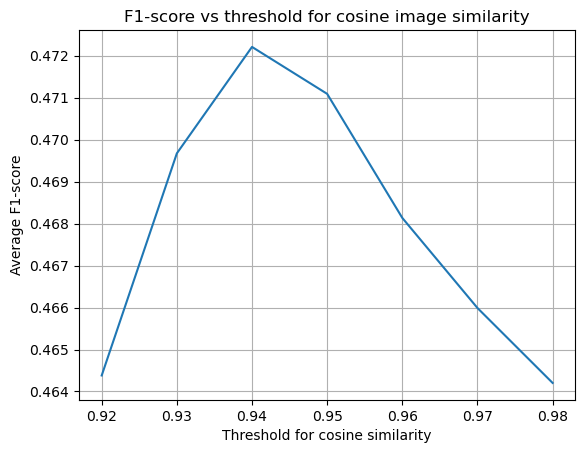

In [68]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_avg_scores)

# Add labels and title
plt.xlabel('Threshold for cosine similarity')
plt.ylabel('Average F1-score')
plt.title('F1-score vs threshold for cosine image similarity')
plt.grid(True)

max_f1 = max(f1_avg_scores)
max_threshold = thresholds[np.argmax(f1_avg_scores)]

# plt.annotate(f"{max_f1}", xy=(max_threshold, max_f1), xytext=(max_threshold, max_f1-0.05),
#              arrowprops=dict(facecolor='black', shrink=0.2), horizontalalignment = 'center')

# Save the plot to a file
plt.savefig('cnn-baseline-thresholds.png')

In [69]:
print(f"Max f1-score: {max_f1}, threshold: {max_threshold}") 

Max f1-score: 0.47221106462230994, threshold: 0.9400000000000001


#### Cosine similarity

In [87]:
text_embeddings = torch.from_numpy(text_embeddings)
embedding_loader = torch.utils.data.DataLoader(
    text_embeddings,
    batch_size=30,
    shuffle=False,
    num_workers=4
)

# compute the pairwise cosine similarity between embeddings
preds = []
for batch in embedding_loader:
    # compute the pairwise cosine similarity within the batch
    # similarity_matrix = cosine_similarity(batch.unsqueeze(1), batch.unsqueeze(0))
    cts = torch.matmul(text_embeddings, batch.T).T
    cts = cts.data.cpu().numpy()
    for k in range(len(batch)):
      # IDX = np.where(cts[k,]>0.7)[0]
      IDX = np.where(cts[k,]>0.7)[0]
      o = train.iloc[IDX].posting_id.values
      preds.append(o)
# # concatenate the similarities and compute the average
# similarities = torch.cat(similarities, dim=0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [88]:
len(preds)

2500

In [89]:
train['oof_text'] = preds
train['f1'] = train.apply(getMetric('oof_text'),axis=1)
print('CV score for baseline =',train.f1.mean())
    

CV score for baseline = 0.40666850257214404


#### Pure Indices based

In [90]:
# text_embeddings = torch.tensor(text_embeddings)
embedding_loader = torch.utils.data.DataLoader(
    text_embeddings,
    batch_size=50,
    shuffle=False,
    num_workers=4
)

# compute the pairwise cosine similarity between embeddings
indices = []
i = 1
for batch in tqdm(embedding_loader):
    # compute the pairwise cosine similarity within the batch
    cts = F.normalize(batch) @ F.normalize(text_embeddings).t()
    for i in range(len(batch)):
      indices.extend(np.where(cts[i]>0.9))

  0%|          | 0/50 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 48%|████▊     | 24/50 [00:00<00:00, 132.31it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

100%|██████████| 50/50 [00:00<00:00, 142.38it/s]


In [91]:
preds = []
for i in range(len(train)):
  preds.append(train.iloc[indices[i]].posting_id.values)
train['oof_text'] = preds

In [92]:
train['f1'] = train.apply(getMetric('oof_text'),axis=1)
print('CV score for baseline =',train.f1.mean())

CV score for baseline = 0.43034384023142774


In [42]:
# Results for Evaluation

# TFIDF
#Faiss
#Cosine
0.4854748963326911
#My Method
0.46851565866626005

# BERT
#Faiss
0.47221106462230994
#Cosine
0.0032822516334360154
#My Method
0.42470765906066443


# BERT + Arcface
#Faiss
0.457528177813392
#Cosine
0.0030378778840720825
#My Method
0.3512061098632143

# BERT + Triplet loss
#Faiss
#Cosing

0.0030378778840720825